In [ ]:
!pip install pycocotools

In [ ]:
import os 

# Use local dataset path from kagglehub download
base_path = "/home/loc-dang/.cache/kagglehub/datasets/awsaf49/coco-2017-dataset/versions/2"

print("Annotations:", os.listdir(os.path.join(base_path, "annotations")))
print("Training images:", len(os.listdir(os.path.join(base_path, "train2017"))))
print("Validation images:", len(os.listdir(os.path.join(base_path, "val2017"))))
print("Test images:", len(os.listdir(os.path.join(base_path, "test2017"))))

Annotations: ['person_keypoints_train2017.json', 'instances_val2017.json', 'instances_train2017.json', 'person_keypoints_val2017.json', 'captions_train2017.json', 'captions_val2017.json']
Training images: 118287
Validation images: 5000
Test images: 40670


# Data visualization

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import Dataset

IMAGE_DIRS = [
    f"{base_path}/train2017",
    f"{base_path}/test2017", 
    f"{base_path}/val2017"
]

# Memory-efficient approach: Just collect image paths, don't load images yet!
image_paths = []
for dir_path in IMAGE_DIRS:
    for fname in os.listdir(dir_path):
        if fname.endswith(".jpg"):
            image_paths.append(os.path.join(dir_path, fname))

print(f"Found {len(image_paths)} images total")

# Limit to a reasonable number for memory constraints
max_images = len(image_paths)  # Reduced for memory efficiency
image_paths = image_paths[:max_images]
print(f"Using {len(image_paths)} images for training")


100%|██████████| 1000/1000 [00:16<00:00, 61.44it/s]


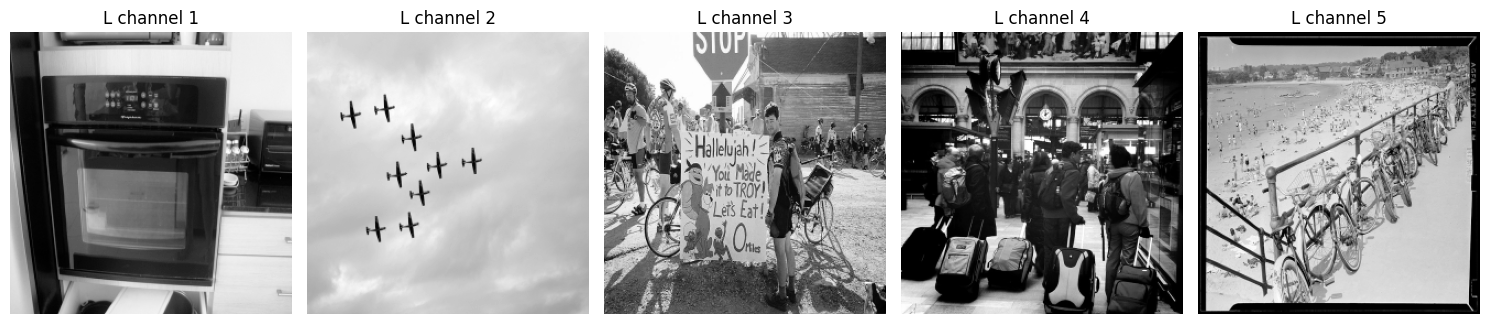

In [ ]:
# Memory-efficient Dataset class - loads images on-the-fly!
class ColorizationDataset(Dataset):
    def __init__(self, image_paths, color_bins):
        self.image_paths = image_paths
        self.color_bins = color_bins
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        try:
            # Load and process image on-demand
            img_bgr = cv2.imread(img_path)
            if img_bgr is None:
                # Return a dummy image if loading fails
                L = np.zeros((256, 256), dtype=np.float32)
                ab_class = np.zeros((256, 256), dtype=np.int64)
                return torch.tensor(L).unsqueeze(0), torch.tensor(ab_class)
            
            # Resize to 256x256
            img_bgr = cv2.resize(img_bgr, (256, 256), interpolation=cv2.INTER_AREA)
            
            # Convert to LAB and split
            img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2Lab)
            L, a, b = cv2.split(img_lab)
            ab = np.stack([a, b], axis=-1)
            
            # Convert AB to class indices
            ab_tensor = torch.tensor(ab, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # (1, 2, H, W)
            ab_classes = self.ab_to_class_indices(ab_tensor, self.color_bins)
            
            # Normalize L channel to [0, 1]
            L = L.astype(np.float32) / 255.0
            
            return torch.tensor(L).unsqueeze(0), ab_classes.squeeze(0)
            
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return dummy data on error
            L = np.zeros((256, 256), dtype=np.float32)
            ab_class = np.zeros((256, 256), dtype=np.int64)
            return torch.tensor(L).unsqueeze(0), torch.tensor(ab_class)
    
    def ab_to_class_indices(self, ab_batch, color_bins):
        """Convert AB values to class indices"""
        if isinstance(ab_batch, np.ndarray):
            ab_batch = torch.from_numpy(ab_batch)
        
        N, _, H, W = ab_batch.shape
        ab_pixels = ab_batch.permute(0, 2, 3, 1).reshape(-1, 2)  # (N*H*W, 2)
        ab_np = ab_pixels.numpy()
        
        # Broadcasting for distance calculation
        diff = ab_np[:, None, :] - color_bins[None, :, :]  # (N*H*W, 313, 2)
        distances = np.sum(diff**2, axis=2)  # (N*H*W, 313)
        class_indices = np.argmin(distances, axis=1)  # (N*H*W,)
        
        return torch.tensor(class_indices.reshape(N, H, W), dtype=torch.long)


# Training process
## Model definition

## Convolution Output Size Formula

Given:
- Input size `X`: `m × n` (Height × Width)
- Kernel size: `k × k`
- Stride: `s`
- Padding: `p`

The output size `Y` after applying a 2D convolution is:

$$
\text{Output Height} = \left\lfloor \frac{m - k + 2p}{s} \right\rfloor + 1
$$

$$
\text{Output Width} = \left\lfloor \frac{n - k + 2p}{s} \right\rfloor + 1
$$

So the output matrix `Y` has size:

$$
Y \in \mathbb{R}^{\left(\left\lfloor \frac{m - k + 2p}{s} \right\rfloor + 1\right) \times \left(\left\lfloor \frac{n - k + 2p}{s} \right\rfloor + 1\right)}
$$

---

### ✅ Example:

If:
- Input: `m = 32`, `n = 32`
- Kernel size: `k = 5`
- Padding: `p = 0`
- Stride: `s = 1`

Then:

$$
\text{Output Height} = \left\lfloor \frac{32 - 5 + 0}{1} \right\rfloor + 1 = 28
$$

$$
\text{Output Width} = \left\lfloor \frac{32 - 5 + 0}{1} \right\rfloor + 1 = 28
$$

Output size: `28 × 28`

---

### 🔎 Note:

To keep the same size as the input:
- Use **"same" padding**:
  
  $$
  p = \frac{k - 1}{2} \quad \text{(when } k \text{ is odd)}
  $$



In [5]:
import torch.nn as nn

class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, stride=2, padding=1), nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=2, padding=1), nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, 3, stride=2, padding=1), nn.ReLU(),
            nn.BatchNorm2d(512)
        )

        # Optional middle block (refinement / deeper processing)
        self.refiner = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 313, 4, stride=2, padding=1)
        )
    def forward(self, x):
        encoder = self.encoder(x)
        for _ in range(3):  # Apply refiner block 3 times
            encoder = self.refiner(encoder)
        decoder = self.decoder(encoder)
        return decoder

## Change ground truth from ab-channel to 714 channels corresponding to 714 distinct colors

In [ ]:
# Fast pre-computed quantization (much faster than K-means!)
def create_ab_quantization(n_bins=313):
    """
    Create pre-computed AB color space quantization bins
    This is much faster than K-means clustering
    """
    # Define AB color space range: A and B channels are typically [-110, 110]
    a_range = np.linspace(-110, 110, int(np.sqrt(n_bins)))
    b_range = np.linspace(-110, 110, int(np.sqrt(n_bins)))
    
    # Create grid of all AB combinations
    a_grid, b_grid = np.meshgrid(a_range, b_range)
    color_bins = np.column_stack([a_grid.flatten(), b_grid.flatten()])
    
    # Take only the first n_bins (in case of rounding)
    return color_bins[:n_bins]

n_bins = 313
color_bins = create_ab_quantization(n_bins)  # shape (313, 2) - MUCH faster!
print(f"Created {len(color_bins)} color bins in AB space")

def ab_to_class_indices(ab_batch, color_bins):
    """
    ab_batch: (N, 2, H, W) or (N, H, W, 2)
    color_bins: (313, 2)
    returns: (N, H, W) — class indices
    """
    if isinstance(ab_batch, np.ndarray):
        ab_batch = torch.from_numpy(ab_batch)
    
    # Handle different input formats
    if ab_batch.shape[1] == 2:  # (N, 2, H, W) format
        N, _, H, W = ab_batch.shape
        ab_pixels = ab_batch.permute(0, 2, 3, 1).reshape(-1, 2)  # (N*H*W, 2)
    else:  # (N, H, W, 2) format
        N, H, W, _ = ab_batch.shape
        ab_pixels = ab_batch.reshape(-1, 2)  # (N*H*W, 2)
    
    # Convert to numpy for distance calculation (faster than cdist with torch)
    ab_np = ab_pixels.numpy()
    
    # Use broadcasting for faster distance calculation than scipy.spatial.distance.cdist
    # ab_np: (N*H*W, 2), color_bins: (313, 2)
    diff = ab_np[:, None, :] - color_bins[None, :, :]  # (N*H*W, 313, 2)
    distances = np.sum(diff**2, axis=2)  # (N*H*W, 313) - squared distances
    class_indices = np.argmin(distances, axis=1)  # (N*H*W,)
    
    return torch.tensor(class_indices.reshape(N, H, W), dtype=torch.long)


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Split data 80 - 20 (memory-efficient way)

In [ ]:
# Split image paths instead of loaded images
from sklearn.model_selection import train_test_split

train_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)

print(f"Training images: {len(train_paths)}")
print(f"Testing images: {len(test_paths)}")

# Create datasets (these don't load images yet!)
train_dataset = ColorizationDataset(train_paths, color_bins)
test_dataset = ColorizationDataset(test_paths, color_bins)

## Fiting model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Create DataLoaders (memory-efficient!)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)  # Reduced batch size
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

In [ ]:
# Initialize model
model = ColorizationNet()
model = model.to(device)

# Loss function and optimizer  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Training loop
num_epochs = 1000  # Reduced epochs for testing

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Print progress every 50 batches
        if (i + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed, Average Loss: {avg_loss:.4f}")

print("Training completed!")


In [ ]:
# Import libraries for model saving
from safetensors.torch import save_file, load_file
import os
import json
from datetime import datetime

In [ ]:
# Save the trained model
print("\n" + "="*50)
print("💾 Saving trained model...")
print("="*50)

# Create a directory for saved models if it doesn't exist
os.makedirs("saved_models", exist_ok=True)

# Create a timestamp for the model filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"saved_models/colorization_model_{timestamp}.safetensors"

# Save the model state dict using safetensors
save_file(model.state_dict(), model_filename)
print(f"✅ Model saved as: {model_filename}")

# Save training metadata
metadata = {
    "model_name": "Colorization CNN",
    "epochs": num_epochs,
    "batch_size": 8,
    "learning_rate": 0.001,
    "optimizer": "Adam",
    "loss_function": "CrossEntropyLoss",
    "num_color_bins": 313,
    "input_size": "256x256",
    "architecture": "encoder_decoder_with_refiner",
    "dataset": "COCO 2017",
    "num_training_images": len(train_paths),
    "num_testing_images": len(test_paths),
    "train_test_split": "80/20",
    "color_space": "LAB",
    "training_date": datetime.now().isoformat(),
    "final_avg_loss": avg_loss
}

# Save metadata as JSON
metadata_filename = f"saved_models/training_metadata_{timestamp}.json"
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"✅ Training metadata saved as: {metadata_filename}")
print("\n🎉 Model and metadata saved successfully!")
print(f"📁 Check the 'saved_models' directory for your files.")

In [ ]:
# Functions to load saved models
def load_colorization_model(model_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Load a saved colorization model from safetensors file
    
    Args:
        model_path: Path to the .safetensors file
        device: Device to load the model on ('cuda' or 'cpu')
    
    Returns:
        Loaded model ready for inference
    """
    print(f"Loading model from: {model_path}")
    
    # Initialize the model architecture (same as training)
    model = ColorizationNet()
    
    # Load the saved state dict
    state_dict = load_file(model_path)
    model.load_state_dict(state_dict)
    
    # Move to device and set to evaluation mode
    model = model.to(device)
    model.eval()
    
    print(f"✅ Model loaded successfully!")
    print(f"🎯 Model is on device: {next(model.parameters()).device}")
    print(f"🔧 Model is in evaluation mode: {not model.training}")
    
    return model

def demo_load_model():
    """
    Demo function showing how to load the most recent saved model
    """
    # List available saved models
    if os.path.exists("saved_models"):
        saved_models = [f for f in os.listdir("saved_models") if f.endswith(".safetensors")]
        if saved_models:
            print("Available saved models:")
            for i, model_file in enumerate(saved_models):
                print(f"  {i+1}. {model_file}")
            
            # Load the most recent model (last in list when sorted)
            latest_model = sorted(saved_models)[-1]
            model_path = f"saved_models/{latest_model}"
            
            print(f"\nLoading latest model: {latest_model}")
            loaded_model = load_colorization_model(model_path)
            return loaded_model
        else:
            print("No saved models found in 'saved_models' directory")
            return None
    else:
        print("'saved_models' directory doesn't exist yet. Train the model first!")
        return None

def test_saved_model():
    """
    Test function to verify the saved model can be loaded and used
    """
    try:
        # Try to load the most recent model
        loaded_model = demo_load_model()
        
        if loaded_model is not None:
            print("\n🧪 Testing loaded model...")
            
            # Test with a dummy input
            dummy_input = torch.randn(1, 1, 256, 256).to(device)
            
            with torch.no_grad():
                output = loaded_model(dummy_input)
                print(f"✅ Model inference successful!")
                print(f"   Input shape: {dummy_input.shape}")
                print(f"   Output shape: {output.shape}")
                print(f"   Expected output shape: (1, 313, 256, 256)")
                
                if output.shape == (1, 313, 256, 256):
                    print("🎉 Model loaded and working perfectly!")
                else:
                    print("⚠️  Output shape doesn't match expected dimensions")
        
    except Exception as e:
        print(f"❌ Error testing saved model: {e}")

print("🔧 Model saving and loading functions defined!")
print("💡 After training completes, your model will be automatically saved!")
print("💡 To load a saved model later, use: loaded_model = demo_load_model()")
print("💡 To test a saved model, use: test_saved_model()")

# Test phase - using memory-efficient approach

In [ ]:
# Test with a single image from the test dataset
model.eval()

# Get one batch from test loader
test_iter = iter(test_loader)
test_batch = next(test_iter)
gray_input, ground_truth = test_batch

# Use the first image in the batch
gray_input = gray_input[0:1].to(device)  # shape: [1, 1, H, W]

print(f"Input shape: {gray_input.shape}")

with torch.no_grad():
    output = model(gray_input)  # shape: [1, 313, H, W]
    print(f"Output shape: {output.shape}")

In [ ]:
# Get predicted color classes
pred_classes = output.argmax(dim=1)  # shape: [1, H, W]
print(f"Predicted classes shape: {pred_classes.shape}")

In [ ]:
pred_classes_np = pred_classes.squeeze().cpu().numpy()  # shape: (H, W)
H, W = pred_classes_np.shape
ab_decoded = color_bins[pred_classes_np.flatten()]      # shape: (H*W, 2)
ab_decoded = ab_decoded.reshape(H, W, 2).astype(np.float32)

In [ ]:
gray_input_np = gray_input.squeeze().cpu().numpy()  # (H, W)
lab_img = np.zeros((H, W, 3), dtype=np.float32)
lab_img[..., 0] = gray_input_np * 255.0  # Set L channel (denormalize from [0,1] to [0,255])
lab_img[..., 1:] = ab_decoded   # Set A and B channels

In [ ]:
import cv2
rgb_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2RGB)
rgb_img = np.clip(rgb_img, 0, 1)

import matplotlib.pyplot as plt
plt.imshow(rgb_img)
plt.title("Colorized Image")
plt.axis("off")
plt.show()

In [ ]:
# Optional: Test the saved model loading functionality
print("\n" + "="*50)
print("🧪 Testing saved model functionality...")
print("="*50)

# Test loading the saved model
test_saved_model()